# How can frog grow its tail back?


## Data accession

The link provided in canvas leads to a .h5ad file instead of a zipfile, so read that directly instead.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
%pip install anndata -q
%pip install scanpy -q
%pip install igraph -q
%pip install umap-learn==0.5.8 -q
%pip install louvain
%pip install leidenalg
%pip install warnings
%pip install magic-impute
%pip install pyALRA

In [ ]:
import igraph as ig
import magic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score
import umap
import warnings

### Read h5ad and print the table

In [ ]:
adata = sc.read_h5ad('/content/drive/MyDrive/5243_projects/project_1/cleaned_processed_frogtail.h5ad')
# convert X from sparse to normal DF
adata.X.todense()

/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# LOCAL version
adata = sc.read_h5ad('cleaned_processed_frogtail.h5ad')
adata.X.todense()

C:\Users\songy\AppData\Local\Programs\Python\Python311\Lib\functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(13199, 31535))

## Starter step 1: replicate 1B

### This is the most faithful replicate of essay procedure

C:\Users\songy\AppData\Local\Temp\ipykernel_1948\664415188.py:10: RuntimeWarning: invalid value encountered in divide
  fano_factor = var_expr / mean_expr


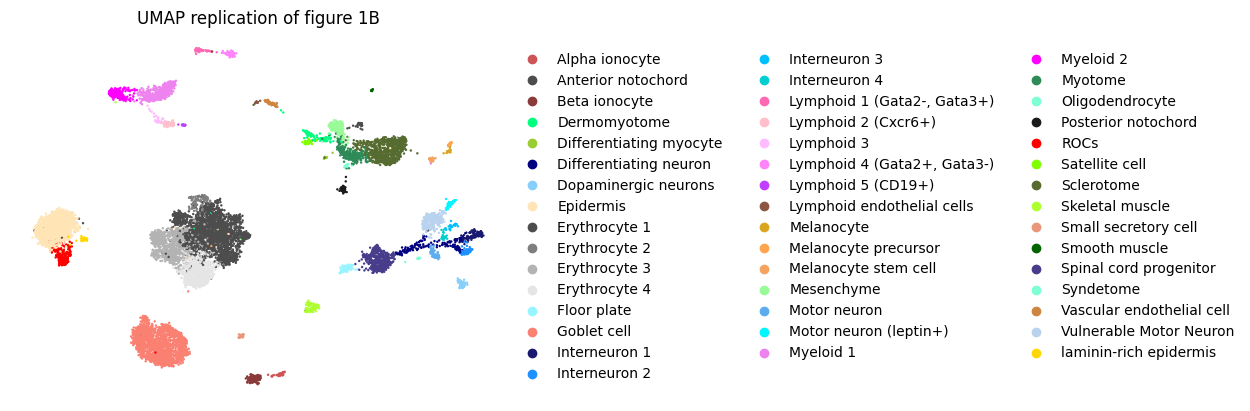

In [ ]:
sc.pp.normalize_total(adata)

# Some custom parameters
lowmean_q = 0.05
highmean_q = 0.8
fano_q = 0.65

mean_expr = adata.X.mean(axis=0).A1
var_expr = adata.X.power(2).mean(axis=0).A1 - np.power(mean_expr, 2)
fano_factor = var_expr / mean_expr

lowmean_thresh = np.quantile(mean_expr, lowmean_q)
highmean_thresh = np.quantile(mean_expr, highmean_q)

fano_thresh = np.quantile(fano_factor[~np.isnan(fano_factor)], fano_q)

adata.var['highly_variable'] = (
    (mean_expr >= lowmean_thresh) &
    (mean_expr <= highmean_thresh) &
    (fano_factor >= fano_thresh)
)

# These parameters are from script.R by author
cluster_n_neighbors = 10
walktrap_steps = 10
random_seed_1 = 3
random_seed_2 = 8

adata_hvg = adata[:, adata.var['highly_variable']].copy()
log2_hvg_data = np.log2(adata_hvg.X.toarray() + 1)

umap_graph_cluster = umap.umap_.fuzzy_simplicial_set(
    X=log2_hvg_data,
    n_neighbors=cluster_n_neighbors,
    random_state=random_seed_1,
    metric='cosine'
)

# Get ready for walktrap
walk_adjacency_ig = ig.Graph.Weighted_Adjacency(umap_graph_cluster[0].toarray(), mode='undirected')

np.random.seed(random_seed_2)
walk_clusters = walk_adjacency_ig.community_walktrap(
    weights='weight',
    steps=walktrap_steps
).as_clustering().membership
adata.obs["walktrap_cluster"] = [str(c) for c in walk_clusters]
adata.obs["walktrap_cluster"] = adata.obs["walktrap_cluster"].astype("category")


# Visual
adata_hvg_viz = adata[:, adata.var['highly_variable']].copy()
adata_hvg_viz.X = log2_hvg_data

sc.pp.neighbors(
    adata_hvg_viz,
    n_neighbors=20,
    random_state=12,
    metric='cosine',
    use_rep='X'
)

sc.tl.umap(
    adata_hvg_viz,
    min_dist=0.5,
    random_state=12
)
adata.obsm['X_umap'] = adata_hvg_viz.obsm['X_umap']

# cluster_colors.csv come from essay github rep
# LOCAL version
# cluster_color_df = pd.read_csv('/content/drive/MyDrive/5243_projects/project_1/cluster_color_hex.csv')
cluster_color_df = pd.read_csv('cluster_color_hex.csv')
cluster_color_dict = dict(zip(cluster_color_df['names'], cluster_color_df['cols']))
cluster_color_categories = list(adata.obs['cluster'].cat.categories)
cluster_color_missing = [c for c in cluster_color_categories if c not in cluster_color_dict]
if cluster_color_missing:
    raise ValueError(f"Cluster color not found in color.csv: {cluster_color_missing}")
cluster_color_palette = [cluster_color_dict[c] for c in cluster_color_categories]

sc.pl.umap(
    adata,
    color='cluster',
    palette=cluster_color_palette,
    frameon=False,
    s=12,
    legend_loc='right margin',
    title='UMAP replication of figure 1B'
)

In [ ]:
num_hvgs = adata.var['highly_variable'].sum()
print(f"Found {num_hvgs} highly variable genes.")

Found 6539 highly variable genes.


There are some differences in cluster structure, and highly variable genes are much more (6k~ vs 2.3k)
than the default processing provided in the sample notebook

## Starter Step 2: clustering with no denoising / batch

In [ ]:
# LOCAL version
# adata = sc.read_h5ad('/content/drive/MyDrive/5243_projects/project_1/cleaned_processed_frogtail.h5ad')
adata = sc.read_h5ad('cleaned_processed_frogtail.h5ad')
adata.X.todense()

C:\Users\songy\AppData\Local\Programs\Python\Python311\Lib\functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(13199, 31535))

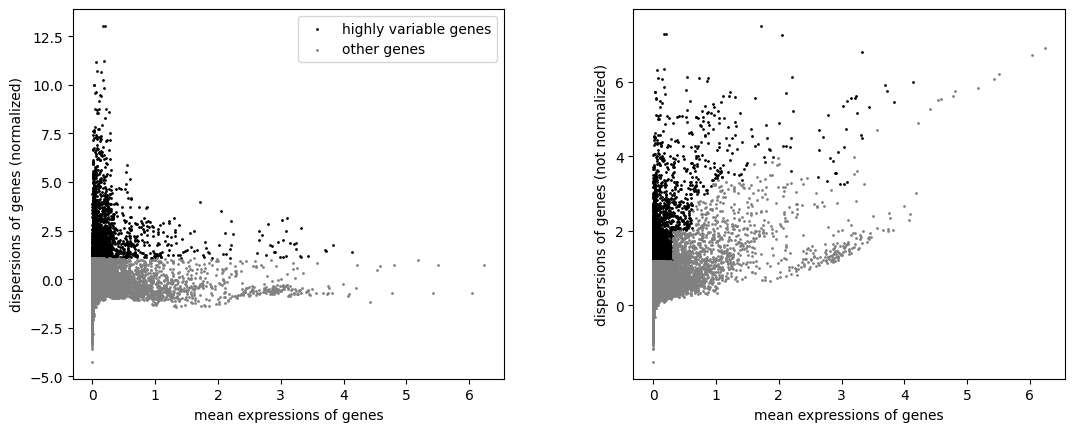

d:\Other_things\PyVenvs\Yu_5243_project_1_venv\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\songy\AppData\Local\Programs\Python\Python311\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


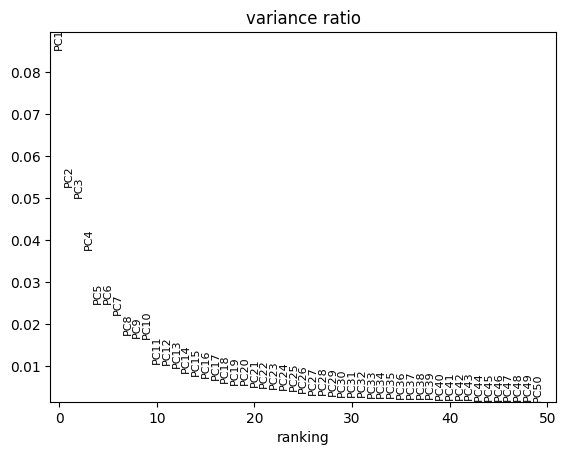

In [ ]:
# layers from this h5ad is empty
# backup X into layers
adata.layers["counts"] = adata.X.copy()
# Normalize X
# pp stands for pre-processing
sc.pp.normalize_total(adata)
# Log(1+x)
sc.pp.log1p(adata)
# Filter genes no cells have
sc.pp.filter_genes(adata, min_cells=3)
# Filter cells that have no genes
sc.pp.filter_cells(adata, min_genes=200)
# Another backup for later use
adata.raw = adata
# Mark the top 2300 highly variable genes (rest not removed)
sc.pp.highly_variable_genes(adata, n_top_genes=2300)
sc.pl.highly_variable_genes(adata)
# Make a subset of hvg true data
adata_hvg = adata[:, adata.var.highly_variable]
sc.pp.scale(adata_hvg, max_value=10)
sc.pp.pca(adata_hvg, n_comps=50)
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50, log=False)

In [ ]:
# Neighborhood Graph
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=50)

In [ ]:
answer_labels = adata_hvg.obs['cluster']
n_target_clusters = len(adata_hvg.obs['leiden_clusters'].unique())
print(n_target_clusters)

46


### PCA + Louvain

In [ ]:
resolutions_to_test_x10 = list(range(160, 251))
resolutions_to_test = [x / 100 for x in resolutions_to_test_x10]
pca_coordinates = adata_hvg.obsm['X_pca']

In [ ]:
adata_hvg_test = adata_hvg.copy()
best_louvain_46_sil = 0
best_louvain_46_res = 0

for res in resolutions_to_test:
    key = f'louvain_res_{res}'
    sc.tl.louvain(adata_hvg_test, resolution=res, key_added=key, random_state=5243)

    n_clusters_found = len(adata_hvg_test.obs[key].unique())
    if (n_clusters_found == 46):
        louvain_labels = adata_hvg_test.obs[key]
        sil = silhouette_score(
            pca_coordinates,
            louvain_labels,
            metric='euclidean',
            random_state=5243
        )
        if (sil > best_louvain_46_sil):
            best_louvain_46_sil = sil
            best_louvain_46_res = res

print(f"The louvain resolution that gives 46 clusters with best silouette score is {best_louvain_46_res:.3f}")

The resolution that gives 46 clusters with best silouette score is 2.270


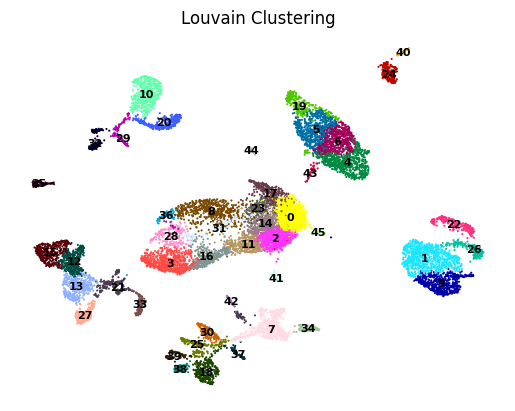

In [ ]:
sc.tl.louvain(adata_hvg, resolution=best_louvain_46_res, key_added='louvain_clusters', random_state=5243)

sc.tl.umap(adata_hvg)
sc.pl.umap(
    adata_hvg,
    color='louvain_clusters',
    title='Louvain Clustering',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
)

### PCA + Leiden

In [ ]:
adata_hvg_test = adata_hvg.copy()
best_leiden_46_sil = 0
best_leiden_46_res = 0

for res in resolutions_to_test:
    key = f'leiden_res_{res}'
    sc.tl.leiden(adata_hvg_test, resolution=res, key_added=key, random_state=5243)

    n_clusters_found = len(adata_hvg_test.obs[key].unique())
    if (n_clusters_found == 46):
        leiden_labels = adata_hvg_test.obs[key]
        sil = silhouette_score(
            pca_coordinates,
            leiden_labels,
            metric='euclidean',
            random_state=5243
        )
        if (sil > best_leiden_46_sil):
            best_leiden_46_sil = sil
            best_leiden_46_res = res

print(f"The leiden resolution that gives 46 clusters with best silouette score is {best_louvain_46_res:.3f}")

The leiden resolution that gives 46 clusters with best silouette score is 2.270


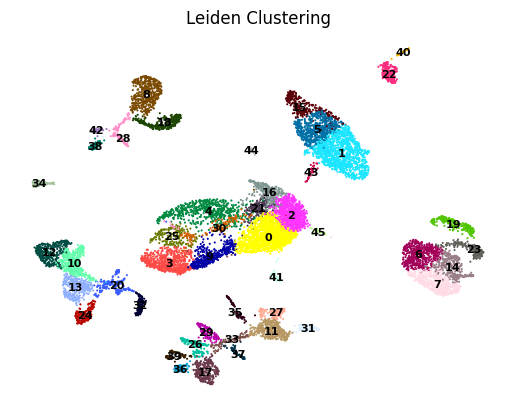

In [ ]:
# Leiden clustering
sc.tl.leiden(adata_hvg, resolution=best_leiden_46_res, key_added='leiden_clusters', random_state=5243)

sc.tl.umap(adata_hvg)
sc.pl.umap(
    adata_hvg,
    color='leiden_clusters',
    title='Leiden Clustering',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
)

### PCA + GMM

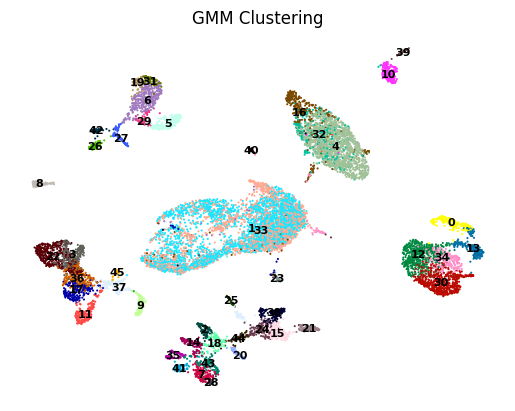

In [ ]:
gmm = GaussianMixture(
    n_components=n_target_clusters,
    covariance_type='full',
    random_state=5243,
    reg_covar=1e-5 # This is increased from default otherwise an error is thrown
)

# Predict and save label
gmm_labels = gmm.fit_predict(pca_coordinates)
adata_hvg.obs['gmm_clusters'] = pd.Categorical(gmm_labels.astype(str))
sc.pl.umap(
    adata_hvg,
    color='gmm_clusters',
    title='GMM Clustering',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
)

### PCA + K-Means

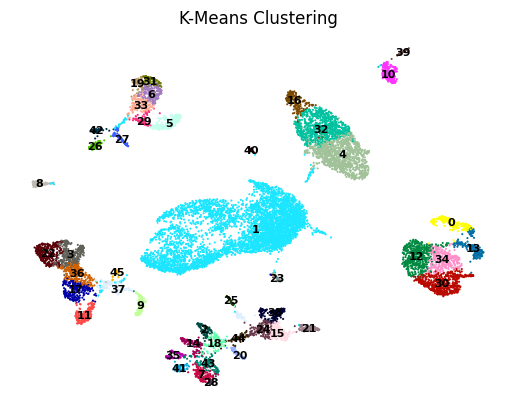

In [ ]:
# K-Means Clustering
kmeans = KMeans(
    n_clusters=n_target_clusters,
    random_state=5243,
    n_init='auto'
)
kmeans_labels = kmeans.fit_predict(pca_coordinates)
adata_hvg.obs['kmeans_clusters'] = pd.Categorical(kmeans_labels.astype(str))

# Plotting
sc.pl.umap(
    adata_hvg,
    color='kmeans_clusters',
    title='K-Means Clustering',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
)

### Comparing Metrics

In [ ]:
def cluster_metrics(adata, pca_c, type):
    label_name = f'{type}_clusters'
    predict_labels = adata.obs[label_name]
    ari_score = adjusted_rand_score(
        answer_labels, # from global
        predict_labels
    )
    sil_score = silhouette_score(
        pca_c, # from global
        predict_labels
    )
    db_score = davies_bouldin_score(
        pca_c,
        predict_labels
    )
    ch_score = calinski_harabasz_score(
        pca_c,
        predict_labels
    )
    return ari_score, sil_score, db_score, ch_score

In [ ]:
# Test metrics
metrics_methods_to_test = ["louvain", "leiden", "gmm", "kmeans"]
metrics_test_results = {}

for m in metrics_methods_to_test:
    loop_ari_score, loop_sil_score, loop_db_score, loop_ch_score = cluster_metrics(adata_hvg, pca_coordinates, m)
    metrics_test_results[m] = {
        "ARI": loop_ari_score,
        "SIL": loop_sil_score,
        "DB": loop_db_score,
        "CH": loop_ch_score
    }

metrics_test_results_df = pd.DataFrame(metrics_test_results)
metrics_test_results_df

,louvain,leiden,gmm,kmeans
ARI,0.379833,0.443631,0.465461,0.489250
SIL,0.202427,0.235230,0.164963,0.460175
DB,1.323746,1.246502,1.650103,1.120714
CH,1377.864258,1523.508057,1551.814819,1922.655640


## Marker Identification

In [ ]:
# By inspecting the data, ST40 only have dpa = 0 or 1, suggesting this is the incompetent group, ST46 is the competent group
# Only keeping dpq=1, the essay did not say much about dpa=3
def identify_condition(c):
    if c["Condition"] == "ST46_0" and c["Epidermis"] == "True":
        return "inc_int"
    elif c["Condition"] == "ST40_0" and c["Epidermis"] == "True":
        return "com_int"
    elif c["Condition"] == "ST46_1" and c["Epidermis"] == "True":
        return "inc_amp"
    elif c["Condition"] == "ST40_1" and c["Epidermis"] == "True":
        return "com_amp"
    else:
        return "ignore"

def rocs_identification(cluster_col):
    # Try to identify the ROC cluster
    adata_identify = adata_hvg.copy()
    # First identify the epiermis cluster
    all_genes = adata_hvg.raw.var_names
    krt_genes = [gene for gene in all_genes if gene.lower().startswith('krt')]
    sc.tl.score_genes(
        adata_identify,
        gene_list=krt_genes,
        score_name='krt_score',
        use_raw=True,
        random_state=0
    )
    # Calculate for genes that have high krt expression
    krt_score_cluster = adata_identify.obs.groupby(cluster_col, observed=True)["krt_score"].mean()
    epidermis_quantile = 0.85
    epidermis_threshold = krt_score_cluster.quantile(epidermis_quantile)
    epidermis_clusters = krt_score_cluster[krt_score_cluster > epidermis_threshold].index.tolist() # This is a list containing clusters suspected to be epidermis
    # Only cells with enough krt expression is kept
    adata_identify.obs["Epidermis"] = "False"
    adata_identify.obs.loc[adata_identify.obs[cluster_col].isin(epidermis_clusters), "Epidermis"] = "True"

    # Apply the earlier defined identification
    adata_identify.obs["id_group"] = adata_identify.obs.apply(identify_condition, axis=1)
    adata_id_filtered = adata_identify[adata_identify.obs["id_group"] != "ignore", :]

    # Use a crosstab heat map to visually check for patterns similar to what is described in the essay
    identify_crosstab = pd.crosstab(
        adata_id_filtered.obs[cluster_col],
        adata_id_filtered.obs["id_group"]
    )
    identify_cross_prop = identify_crosstab.div(identify_crosstab.sum(axis=0), axis=1)
    sns.heatmap(
        identify_cross_prop,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        linewidths=0.5
    )

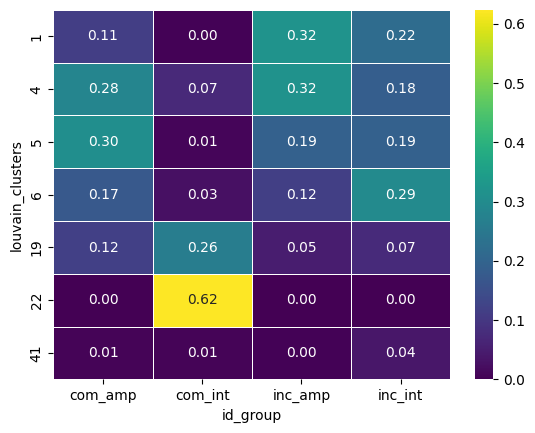

In [ ]:
rocs_identification("louvain_clusters")


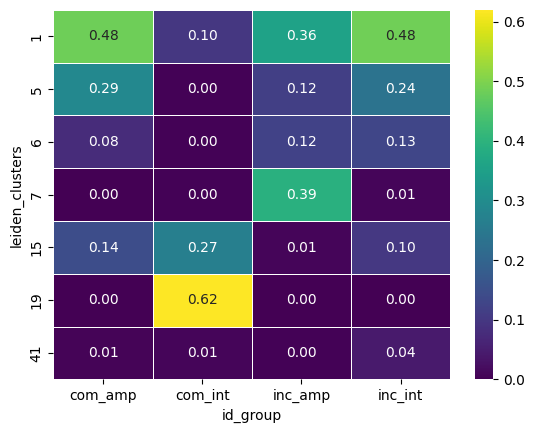

In [ ]:
rocs_identification("leiden_clusters")

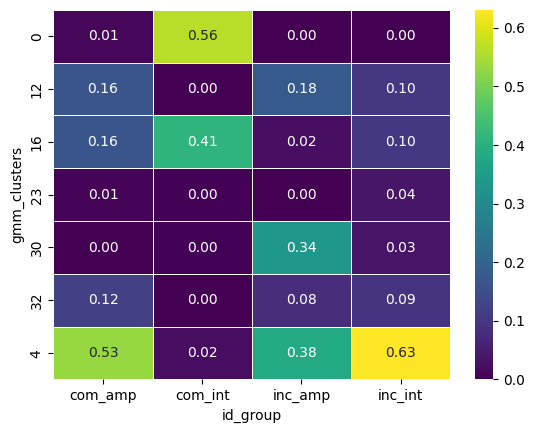

In [ ]:
rocs_identification("gmm_clusters")

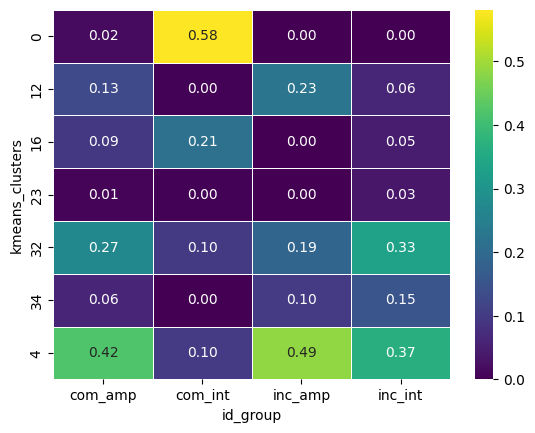

In [ ]:
rocs_identification("kmeans_clusters")

### T-test

In [ ]:
roc_correspond_clusters = {
    "louvain": 19,
    "leiden": 15,
    "gmm": 16,
    "kmeans": 16
}
adata_hvg_marker = adata_hvg.copy()


def marker_identification(adata, method):
    cluster_col_name = f'{method}_clusters'

    output_col_name = f'{method}_ttest_ranks'
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_col_name,
        groups=[str(roc_correspond_clusters[method])],
        method='t-test',
        key_added=output_col_name,
        n_genes=50
    )
    sc.pl.rank_genes_groups_heatmap(
        adata,
        key=output_col_name,
        dendrogram = False,
        vmax=5
    )
    ranked_marker_ttest_df = sc.get.rank_genes_groups_df(
        adata,
        group=str(roc_correspond_clusters[method]),
        key=output_col_name
    )

    output_col_name = f'{method}_wilcoxon_ranks'
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_col_name,
        groups=[str(roc_correspond_clusters[method])],
        method='wilcoxon',
        key_added=output_col_name,
        n_genes=50
    )
    sc.pl.rank_genes_groups_heatmap(
        adata,
        key=output_col_name,
        dendrogram = False,
        vmax=5
    )
    ranked_marker_wilcox_df = sc.get.rank_genes_groups_df(
        adata,
        group=str(roc_correspond_clusters[method]),
        key=output_col_name
    )
    return ranked_marker_ttest_df, ranked_marker_wilcox_df

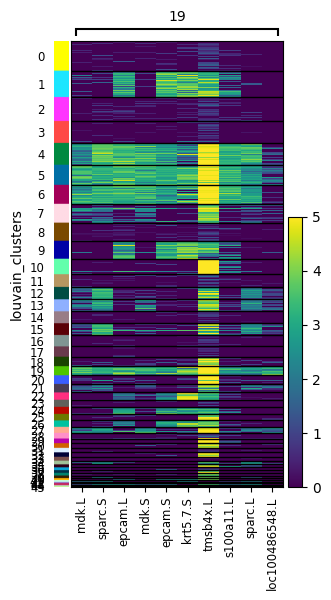

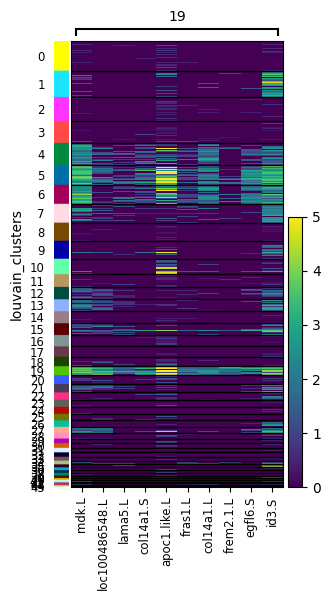

In [ ]:
ranked_marker_dfs = {}
ranked_marker_dfs['louvain_ttest'], ranked_marker_dfs['louvain_wilcox'] = marker_identification(adata_hvg_marker, "louvain")

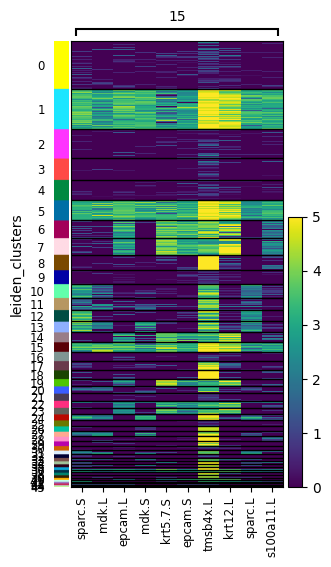

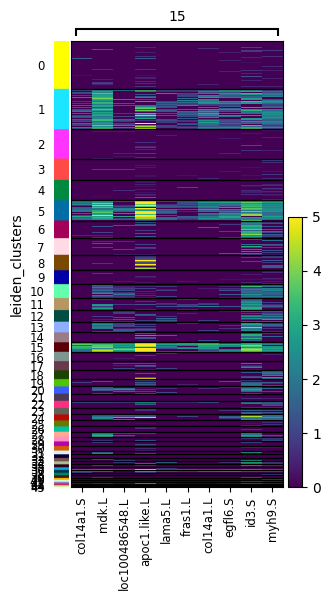

In [ ]:
ranked_marker_dfs['leiden_ttest'], ranked_marker_dfs['leiden_wilcox'] = marker_identification(adata_hvg_marker, "leiden")

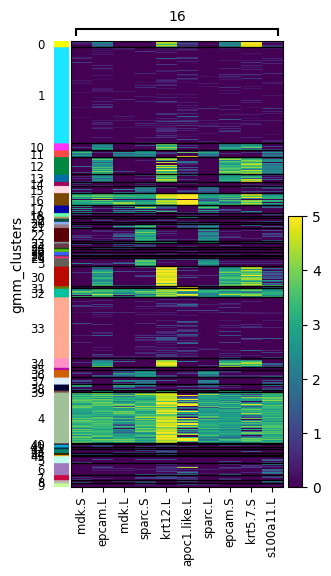

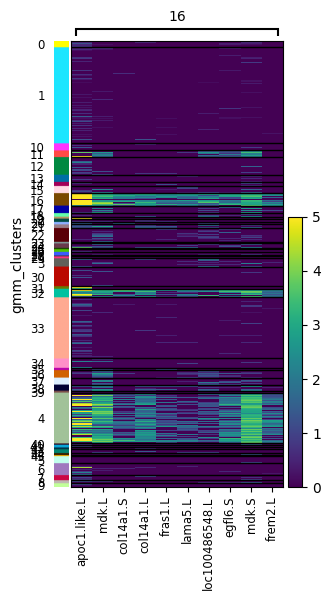

In [ ]:
ranked_marker_dfs['gmm_ttest'], ranked_marker_dfs['gmm_wilcox'] = marker_identification(adata_hvg_marker, "gmm")

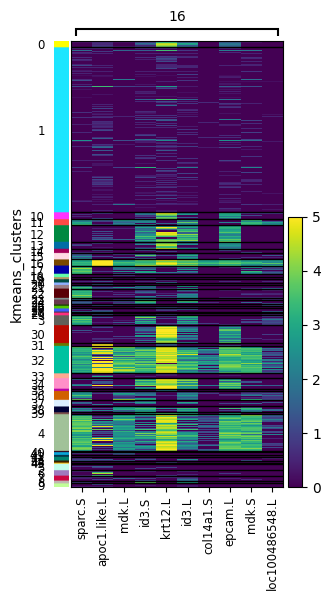

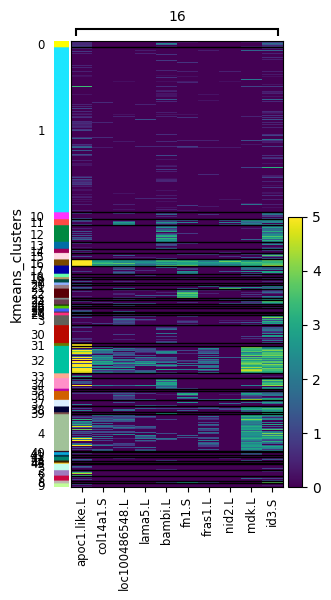

In [ ]:
ranked_marker_dfs['kmeans_ttest'], ranked_marker_dfs['kmeans_wilcox'] = marker_identification(adata_hvg_marker, "kmeans")

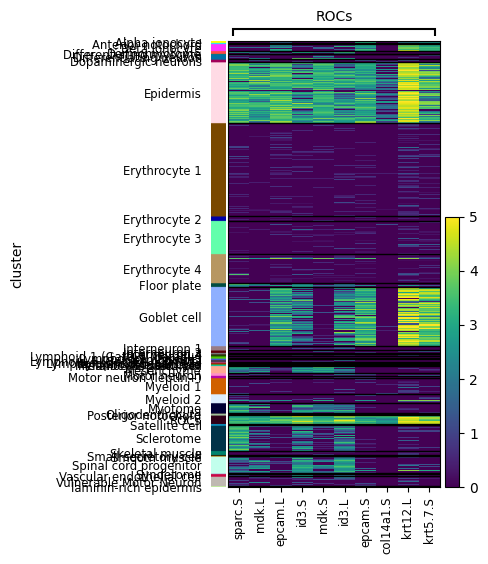

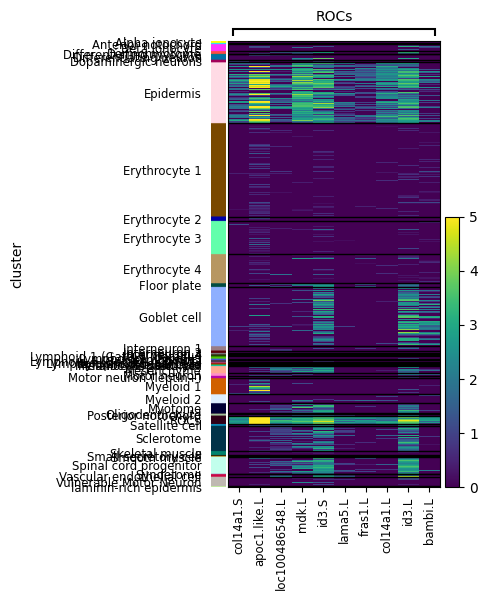

In [ ]:
cluster_col_name = 'cluster'
output_col_name = 'answer_ttest_ranks'
sc.tl.rank_genes_groups(
    adata_hvg_marker,
    groupby=cluster_col_name,
    groups=["ROCs"],
    method='t-test',
    key_added=output_col_name,
    n_genes=50
)
sc.pl.rank_genes_groups_heatmap(
    adata_hvg_marker,
    key=output_col_name,
    dendrogram = False,
    vmax=5
)
answer_marker_ttest_df = sc.get.rank_genes_groups_df(
    adata_hvg_marker,
    group=["ROCs"],
    key=output_col_name
)
output_col_name = 'answer_wilcox_ranks'
sc.tl.rank_genes_groups(
    adata_hvg_marker,
    groupby=cluster_col_name,
    groups=["ROCs"],
    method='wilcoxon',
    key_added=output_col_name,
    n_genes=50
)
sc.pl.rank_genes_groups_heatmap(
    adata_hvg_marker,
    key=output_col_name,
    dendrogram = False,
    vmax=5
)
answer_marker_wilcox_df = sc.get.rank_genes_groups_df(
    adata_hvg_marker,
    group=["ROCs"],
    key=output_col_name
)

In [ ]:
table_3_markers = pd.read_csv("reference_marker_genes.csv", header=None).squeeze("columns")
table_3_markers_tuple = tuple(table_3_markers)

answer_match_ttest = answer_marker_ttest_df['names'].str.startswith(table_3_markers_tuple)
answer_match_ttest_count = answer_match_ttest.sum()
answer_match_ttest_perc = answer_match_ttest_count / len(answer_marker_ttest_df)

answer_match_wilcox = answer_marker_wilcox_df['names'].str.startswith(table_3_markers_tuple)
answer_match_wilcox_count = answer_match_wilcox.sum()
answer_match_wilcox_perc = answer_match_wilcox_count / len(answer_marker_wilcox_df)

In [ ]:
markers_methods_to_test = ["louvain", "leiden", "gmm", "kmeans"]
markers_methods_test_result = {}

for m in markers_methods_to_test:
    markers_methods_test_result[m] = {}
    markers_test_ttest_df_key = f'{m}_ttest'
    markers_test_ttest_df = ranked_marker_dfs[markers_test_ttest_df_key]
    markers_test_wilcox_df_key = f'{m}_wilcox'
    markers_test_wilcox_df = ranked_marker_dfs[markers_test_wilcox_df_key]
    markers_test_ttest_output = 'ttest_perc'
    markers_test_wilcox_output = 'wilcox_perc'

    markers_test_ttest_match = markers_test_ttest_df['names'].str.startswith(table_3_markers_tuple)
    markers_test_ttest_match_count = markers_test_ttest_match.sum()
    markers_test_ttest_match_perc = markers_test_ttest_match_count / len(markers_test_ttest_df)

    markers_test_wilcox_match = markers_test_wilcox_df['names'].str.startswith(table_3_markers_tuple)
    markers_test_wilcox_match_count = markers_test_wilcox_match.sum()
    markers_test_wilcox_match_perc = markers_test_wilcox_match_count / len(markers_test_wilcox_df)

    markers_methods_test_result[m][markers_test_ttest_output] = markers_test_ttest_match_perc
    markers_methods_test_result[m][markers_test_wilcox_output] = markers_test_wilcox_match_perc

markers_methods_test_result['reference'] = {}
markers_methods_test_result['reference']['ttest_perc'] = answer_match_ttest_perc
markers_methods_test_result['reference']['wilcox_perc'] = answer_match_wilcox_perc

markers_methods_test_result_df = pd.DataFrame(markers_methods_test_result)
markers_methods_test_result_df

,louvain,leiden,gmm,kmeans,reference
ttest_perc,0.12,0.12,0.12,0.20,0.14
wilcox_perc,0.12,0.12,0.14,0.18,0.18


## Denoising

### kNN Smoothing

In [ ]:
adata_knn_smooth = adata_hvg.copy()
adata_knn_smooth.layers['log'] = adata_hvg.X.copy()

sc.pp.neighbors(adata_knn_smooth, n_neighbors=15, use_rep='X')
denoise_connectivity_mat = adata_knn_smooth.obsp['connectivities']
denoise_knn_smooth_mat = denoise_connectivity_mat @ adata_knn_smooth.layers['log']
adata_knn_smooth.layers['knn_smooth'] = denoise_knn_smooth_mat
adata_knn_smooth.X = adata_knn_smooth.layers['knn_smooth'].copy()

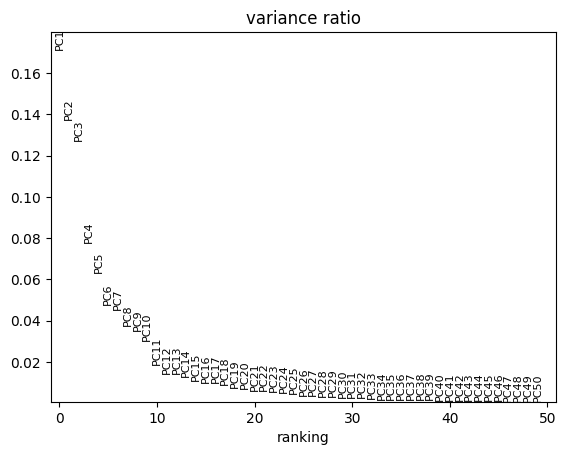

In [ ]:
sc.pp.pca(adata_knn_smooth, n_comps=50)
sc.pl.pca_variance_ratio(adata_knn_smooth, n_pcs=50, log=False)

In [ ]:
sc.pp.neighbors(adata_knn_smooth, n_neighbors=15, n_pcs=40)

resolutions_to_test_x10 = list(range(90, 120))
resolutions_to_test = [x / 100 for x in resolutions_to_test_x10]
pca_coordinates_knn = adata_knn_smooth.obsm['X_pca']
adata_knn_smooth_test = adata_knn_smooth.copy()
best_knn_smooth_leiden_46_sil = 0
best_knn_smooth_leiden_46_res = 0

for res in resolutions_to_test:
    key = f'leiden_res_{res}'
    sc.tl.leiden(adata_knn_smooth_test, resolution=res, key_added=key, random_state=5243)

    n_clusters_found = len(adata_knn_smooth_test.obs[key].unique())
    if (n_clusters_found == 46):
        leiden_labels = adata_knn_smooth_test.obs[key]
        sil = silhouette_score(
            pca_coordinates_knn,
            leiden_labels,
            metric='euclidean',
            random_state=5243
        )
        if (sil > best_knn_smooth_leiden_46_sil):
            best_knn_smooth_leiden_46_sil = sil
            best_knn_smooth_leiden_46_res = res

print(f"The leiden resolution that gives 46 clusters with best silouette score is {best_knn_smooth_leiden_46_res:.3f}")

The leiden resolution that gives 46 clusters with best silouette score is 1.060


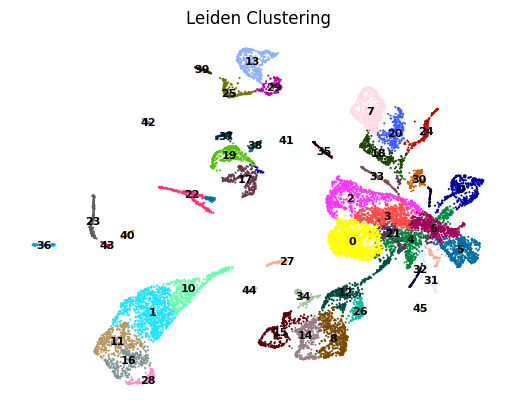

In [ ]:
# knn smoothing + leiden
sc.tl.leiden(adata_knn_smooth, resolution=best_knn_smooth_leiden_46_res, key_added='leiden_clusters', random_state=5243)
sc.tl.umap(adata_knn_smooth)
sc.pl.umap(
    adata_knn_smooth,
    color='leiden_clusters',
    title='Leiden Clustering',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
)

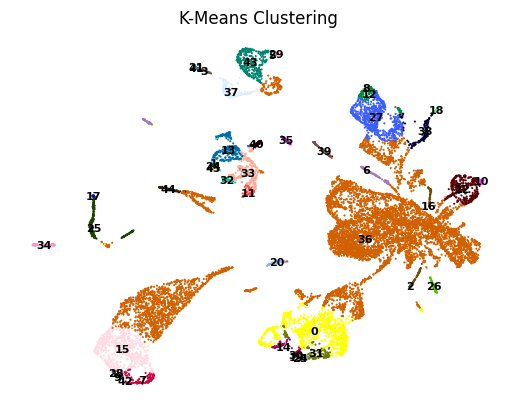

In [ ]:
# knn smoothing + K-Means
kmeans_knn_smooth = KMeans(
    n_clusters=n_target_clusters,
    random_state=5243,
    n_init='auto'
)
kmeans_knn_smooth_labels = kmeans_knn_smooth.fit_predict(pca_coordinates_knn)
adata_knn_smooth.obs['kmeans_clusters'] = pd.Categorical(kmeans_knn_smooth_labels.astype(str))

# Plotting
sc.pl.umap(
    adata_knn_smooth,
    color='kmeans_clusters',
    title='K-Means Clustering',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
)

### MAGIC smoothing

In [ ]:
adata_magic_smooth = adata_hvg.copy()
adata_magic_smooth.layers['log'] = adata_hvg.X.copy()

magic_smooth = magic.MAGIC(t=3)
magic_smooth_imputed = magic_smooth.fit_transform(adata_magic_smooth.layers['log'])
adata_magic_smooth.layers['magic'] = magic_smooth_imputed
adata_magic_smooth.X = adata_magic_smooth.layers['magic'].copy()

Calculating MAGIC...
  Running MAGIC on 13199 cells and 2300 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.68 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.30 seconds.
    Calculating affinities...
    Calculated affinities in 1.62 seconds.
  Calculated graph and diffusion operator in 3.63 seconds.
  Calculating imputation...
  Calculated imputation in 1.54 seconds.
Calculated MAGIC in 5.19 seconds.


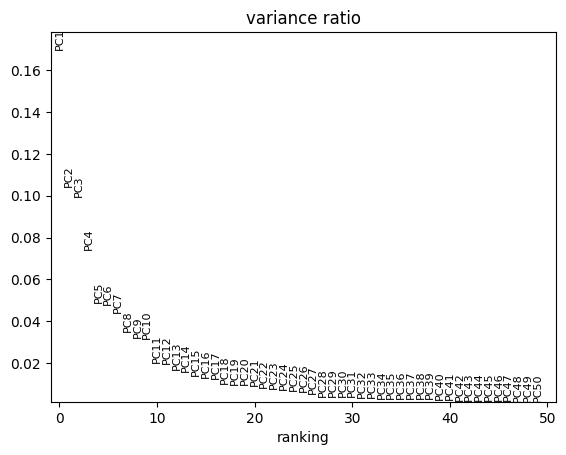

In [ ]:
sc.pp.pca(adata_magic_smooth, n_comps=50)
sc.pl.pca_variance_ratio(adata_magic_smooth, n_pcs=50, log=False)

In [ ]:
sc.pp.neighbors(adata_magic_smooth, n_neighbors=15, n_pcs=40)

resolutions_to_test_x10 = list(range(60, 91))
resolutions_to_test = [x / 100 for x in resolutions_to_test_x10]
pca_coordinates_magic = adata_magic_smooth.obsm['X_pca']
adata_magic_smooth_test = adata_magic_smooth.copy()
best_magic_smooth_leiden_46_sil = 0
best_magic_smooth_leiden_46_res = 0

for res in resolutions_to_test:
    key = f'leiden_res_{res}'
    sc.tl.leiden(adata_magic_smooth_test, resolution=res, key_added=key, random_state=5243)

    n_clusters_found = len(adata_magic_smooth_test.obs[key].unique())
    if (n_clusters_found == 46):
        leiden_labels = adata_magic_smooth_test.obs[key]
        sil = silhouette_score(
            pca_coordinates_magic,
            leiden_labels,
            metric='euclidean',
            random_state=5243
        )
        if (sil > best_magic_smooth_leiden_46_sil):
            best_magic_smooth_leiden_46_sil = sil
            best_magic_smooth_leiden_46_res = res

print(f"The leiden resolution that gives 46 clusters with best silouette score is {best_magic_smooth_leiden_46_res:.3f}")

The leiden resolution that gives 46 clusters with best silouette score is 0.660


d:\Other_things\PyVenvs\Yu_5243_project_1_venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


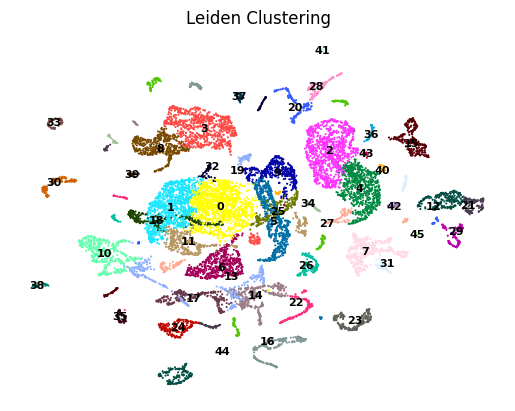

In [ ]:
# magic smoothing + leiden
sc.tl.leiden(adata_magic_smooth, resolution=best_magic_smooth_leiden_46_res, key_added='leiden_clusters', random_state=5243)
sc.tl.umap(adata_magic_smooth)
sc.pl.umap(
    adata_magic_smooth,
    color='leiden_clusters',
    title='Leiden Clustering',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
)

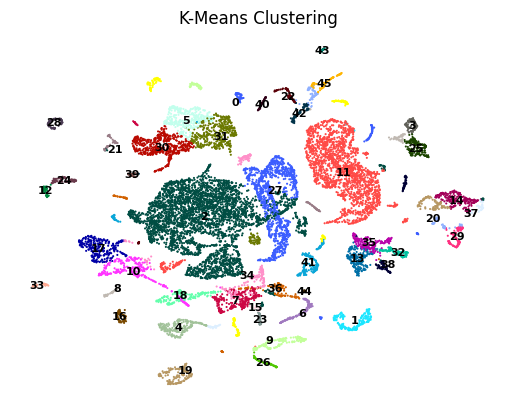

In [ ]:
# magic smoothing + K-Means
kmeans_magic_smooth = KMeans(
    n_clusters=n_target_clusters,
    random_state=5243,
    n_init='auto'
)
kmeans_magic_smooth_labels = kmeans_magic_smooth.fit_predict(pca_coordinates_magic)
adata_magic_smooth.obs['kmeans_clusters'] = pd.Categorical(kmeans_magic_smooth_labels.astype(str))

# Plotting
sc.pl.umap(
    adata_magic_smooth,
    color='kmeans_clusters',
    title='K-Means Clustering',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
)

In [ ]:
metrics_methods_to_test_denoise = ["leiden", "kmeans"]
metrics_test_denoise_results = {}
metrics_test_denoise_results["knn_smoothing + leiden"] = {}
metrics_test_denoise_results["magic + leiden"] = {}
metrics_test_denoise_results["knn_smoothing + kmeans"] = {}
metrics_test_denoise_results["magic + kmeans"] = {}

(metrics_test_denoise_results["knn_smoothing + leiden"]["ari"],
metrics_test_denoise_results["knn_smoothing + leiden"]["sil"],
metrics_test_denoise_results["knn_smoothing + leiden"]["dh"],
metrics_test_denoise_results["knn_smoothing + leiden"]["ch"]) = cluster_metrics(adata_knn_smooth, pca_coordinates_knn, "leiden")

(metrics_test_denoise_results["knn_smoothing + kmeans"]["ari"],
metrics_test_denoise_results["knn_smoothing + kmeans"]["sil"],
metrics_test_denoise_results["knn_smoothing + kmeans"]["dh"],
metrics_test_denoise_results["knn_smoothing + kmeans"]["ch"]) = cluster_metrics(adata_knn_smooth, pca_coordinates_knn, "kmeans")

(metrics_test_denoise_results["magic + leiden"]["ari"],
metrics_test_denoise_results["magic + leiden"]["sil"],
metrics_test_denoise_results["magic + leiden"]["dh"],
metrics_test_denoise_results["magic + leiden"]["ch"]) = cluster_metrics(adata_magic_smooth, pca_coordinates_magic, "leiden")

(metrics_test_denoise_results["magic + kmeans"]["ari"],
metrics_test_denoise_results["magic + kmeans"]["sil"],
metrics_test_denoise_results["magic + kmeans"]["dh"],
metrics_test_denoise_results["magic + kmeans"]["ch"]) = cluster_metrics(adata_magic_smooth, pca_coordinates_magic, "kmeans")

metrics_test_denoise_results_df = pd.DataFrame(metrics_test_denoise_results)
metrics_test_denoise_results_df

,knn_smoothing + leiden,magic_smoothing + leiden,knn_smoothing + kmeans,magic_smoothing + kmeans
ari,0.303812,0.423347,0.199608,0.599911
sil,0.084432,0.321882,0.457717,0.541761
dh,1.423777,1.055076,0.874762,0.763024
ch,338.328979,1637.848267,1299.073486,4014.731689


In [ ]:
metrics_test_results_df

,louvain,leiden,gmm,kmeans
ARI,0.379833,0.443631,0.465461,0.489250
SIL,0.202427,0.235230,0.164963,0.460175
DB,1.323746,1.246502,1.650103,1.120714
CH,1377.864258,1523.508057,1551.814819,1922.655640


In [ ]:
answer_ROCs_label = "ROCs"
answer_is_ROCs = adata_hvg.obs['cluster'] == answer_ROCs_label
adata_answer_ROCs = adata_hvg[answer_is_ROCs, :]
ROCs_dist_clusters = adata_answer_ROCs.obs['kmeans_clusters'].value_counts()

ROCs_dist_clusters


kmeans_clusters
16    177
32     66
1       5
4       4
23      1
8       1
Name: count, dtype: int64

leiden=26
kmeans=13
gmm=13